In [61]:
import numpy as np
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.preprocessing import TransactionEncoder
from datetime import date
from datetime import datetime

from scipy.sparse import csr_matrix

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

from mpl_toolkits.mplot3d import Axes3D

In [63]:
df = pd.read_csv('edzd_trans_data.csv')
# print type of each column
for col in df.columns:
    print("Type of column", col, "is", df[col].dtype)

Type of column transaction_id is object
Type of column sales_datetime is object
Type of column customer_id is object
Type of column product_id is object
Type of column quantity is float64
Type of column price is float64
Type of column category_id is int64
Type of column parent_id is int64
Type of column store_id is int64
Type of column department_id is int64
Type of column salesperson_id is int64


In [65]:
# change the type of product_id to int and number them from 1 to number of different product_ids
df['product_id'] = df['product_id'].astype('category')
df['product_id'] = df['product_id'].cat.codes

# change the type of transaction_id to int and number them from 1 to number of different transaction_ids
df['transaction_id'] = df['transaction_id'].astype('category')
df['transaction_id'] = df['transaction_id'].cat.codes

# df['customer_id'] = df['customer_id'].astype('string')

for col in df.columns:
    print("Type of column", col, "is", df[col].dtype)

Type of column transaction_id is int32
Type of column sales_datetime is object
Type of column customer_id is object
Type of column product_id is int32
Type of column quantity is float64
Type of column price is float64
Type of column category_id is int64
Type of column parent_id is int64
Type of column store_id is int64
Type of column department_id is int64
Type of column salesperson_id is int64


In [67]:
print(df.head())
print(df.shape)

   transaction_id       sales_datetime customer_id  product_id  quantity  \
0          680577  2011-01-01 09:04:00          -1         157       1.0   
1         3148654  2011-01-01 09:04:00          -1       43930       1.0   
2         3148654  2011-01-01 09:04:00          -1       12666       1.0   
3          651357  2011-01-01 09:08:00          -1       39576       1.0   
4          651357  2011-01-01 09:08:00          -1       44343       1.0   

   price  category_id  parent_id  store_id  department_id  salesperson_id  
0   13.5          208         29        18              2             108  
1    6.5          179         30        17              2             108  
2    6.5          179         30        17              2             108  
3   10.5          175         29         1              2             108  
4   17.5          208         29         1              2             108  
(8159536, 11)


# Customer lifecycle analysis

In [68]:
# Convert the sales_datetime column to a datetime object
df["sales_datetime"] = pd.to_datetime(df["sales_datetime"])

# Filter out customer_id = -1
filtered = df[df['customer_id'] != '-1']

# Group the data by customer_id
grouped = filtered.groupby("customer_id")

In [69]:
# Define the date range of the data
start_date = min(filtered['sales_datetime']).date()
end_date = max(filtered['sales_datetime']).date()

print(start_date)
print(end_date)

2011-01-03
2014-10-01


In [70]:
# Calculate the frequency of purchases for each customer
frequency = grouped["transaction_id"].count()

# Calculate the total revenue for each customer
revenue = grouped["price"].sum()

# Calculate the recency of the most recent purchase for each customer as the number of days since the last purchase
recency = (pd.to_datetime(end_date) - grouped["sales_datetime"].max()).dt.days

# Create a new DataFrame with the calculated metrics
customer_metrics = pd.DataFrame({"frequency": frequency,
                                 "revenue": revenue,
                                 "recency": recency})

print(customer_metrics)

                                  frequency  revenue  recency
customer_id                                                  
00003096aa2c3b7c9e277aff115041f9          9   252.99      169
000034ae9d033d2aa17adfd83a163e21          6    20.50     1036
00005056baef74980bdfaf57cb4062cd         40   410.80       76
0000720f5904467c903f6edcda89810e          1    10.00      228
00011d7bffad55a41255353bddf21663          6    60.87      439
...                                     ...      ...      ...
fffdebaf23cbcc7f907114207ceb9cfe          4    61.85      310
fffe6e17bac06b5994a1952c957d1f86         11   113.50      147
fffe88e7d7cbcf765fc854c873bdc59b          4   245.84      314
fffed1fc843f40cc45ac453f63df20ff          4    58.93      650
fffefb0f14695f07fb1bef44560b6461          9    89.75      115

[204441 rows x 3 columns]


In [71]:
# Segment the customers based on the metrics
acquisition_customers = customer_metrics[(customer_metrics["frequency"] > 2) &
                                         (customer_metrics["revenue"] > 50) &
                                         (customer_metrics["recency"] < 365*3)]

retention_customers = customer_metrics[(customer_metrics["frequency"] > 2) &
                                       (customer_metrics["revenue"] > 50) &
                                       (customer_metrics["recency"] >= 365*3)]

churn_customers = customer_metrics[(customer_metrics["frequency"] <= 2) |
                                    (customer_metrics["revenue"] <= 50)]

In [72]:
# Analyze the segments
print("There are " + str(len(acquisition_customers)) + " acquisition customers")
print("There are " + str(len(retention_customers)) + " retention customers")
print("There are " + str(len(churn_customers)) + " churn customers")

There are 110420 acquisition customers
There are 1368 retention customers
There are 92653 churn customers


# RMF plot

In [73]:
# Create a new KMeans model
kmeans = KMeans(n_clusters=3)

# Fit the model to the customer metrics data
kmeans.fit(customer_metrics[["recency", "frequency", "revenue"]])

# Assign the cluster labels to the customer metrics data
customer_metrics["cluster"] = kmeans.labels_

# Analyze the clusters
print(customer_metrics.groupby("cluster").mean())

/home/zosia/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


           frequency        revenue     recency
cluster                                        
0          11.583094     143.782962  354.349733
1        8218.207921  108829.683083    9.831683
2         623.638472    6357.392546  172.523874


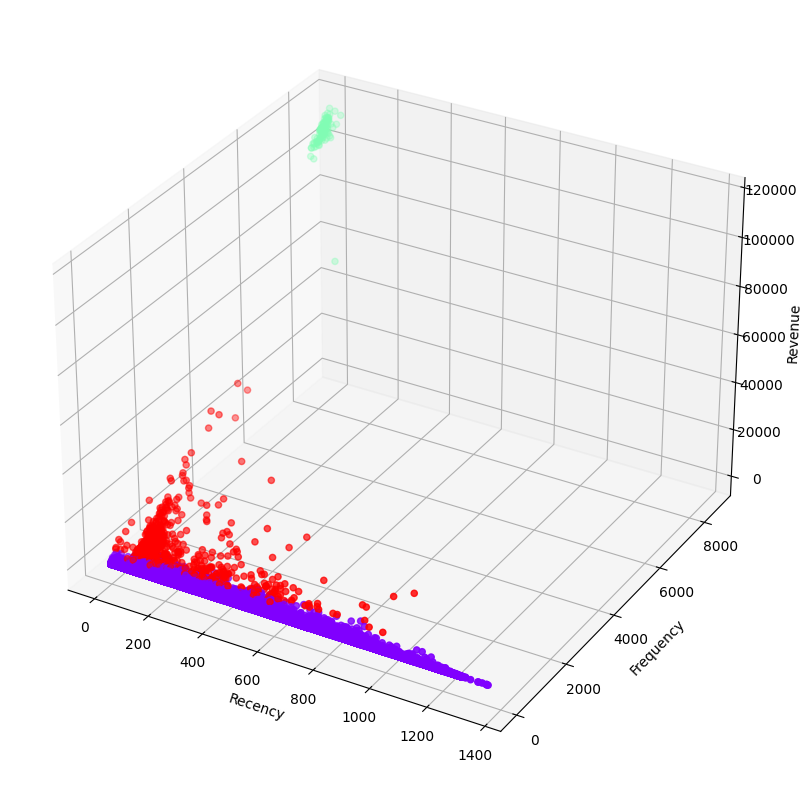

In [74]:
# Create a new figure
fig = plt.figure(figsize=(10, 10))

# Add a 3D subplot to the figure
ax = fig.add_subplot(111, projection='3d')

# Plot the recency, frequency, and monetary value of customers on the 3D axis
ax.scatter(customer_metrics["recency"], customer_metrics["frequency"], customer_metrics["revenue"], c=customer_metrics["cluster"], cmap='rainbow')

# Set the axis labels
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Revenue")

# Show the plot
plt.show()

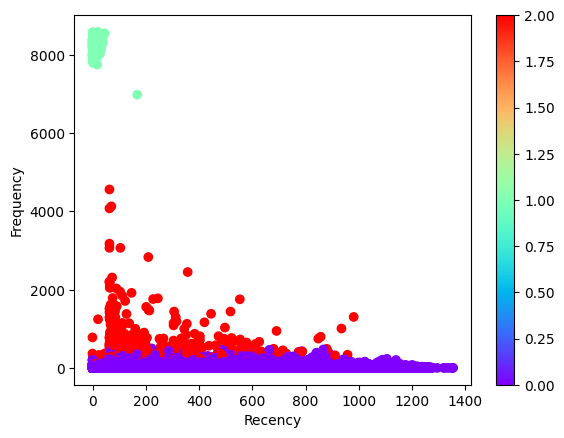

In [75]:
# Assign the cluster labels to the customer metrics data
customer_metrics["cluster"] = kmeans.labels_

# Create a new figure
fig, ax = plt.subplots()

# Plot the customer clusters
scatter = ax.scatter(customer_metrics["recency"], customer_metrics["frequency"], c=customer_metrics["cluster"], cmap="rainbow")

# Add a colorbar to the plot
plt.colorbar(scatter)

# Set the axis labels
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")

# Show the plot
plt.show()